## 1. Instalasi dan Import Library
Pada tahap awal, kita menginstal semua library yang diperlukan untuk menjalankan proyek analisis sentimen secara lengkap. Perintah !pip install digunakan untuk memasang paket-paket seperti google-play-scraper (untuk mengambil ulasan dari Google Play Store), Sastrawi (stemmer khusus bahasa Indonesia), transformers dari Hugging Face (untuk memanfaatkan model IndoBERT), serta wordcloud dan tqdm untuk visualisasi dan progress bar. Setelah itu, dilakukan import berbagai modul penting: pandas untuk pengolahan data dalam bentuk tabel, re untuk pembersihan teks menggunakan regular expression, nltk untuk tokenisasi dasar, serta modul-modul dari scikit-learn (TF-IDF, train-test split, Naive Bayes, metrik evaluasi) yang akan digunakan pada model machine learning klasik. Kita juga mengimpor pipeline dari transformers agar dapat langsung memuat model IndoBERT untuk labelling otomatis, serta tqdm untuk menampilkan progress bar yang memudahkan pemantauan saat proses berjalan lambat (misalnya stemming atau prediksi ribuan ulasan). Terakhir, resource punkt dari NLTK di-download untuk keperluan tokenisasi kalimat jika diperlukan di tahap lanjutan. Dengan menyiapkan semua library ini sejak awal, notebook dapat berjalan tanpa error dan mendukung seluruh alur kerja mulai dari scraping, preprocessing, labelling dengan model canggih, hingga training dan deployment model sentimen.

In [1]:
# Install library
!pip install google-play-scraper Sastrawi transformers wordcloud

# Import semua library
import pandas as pd
import re
import nltk
import time
from datetime import datetime
from google_play_scraper import reviews, Sort
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from transformers import pipeline
from tqdm import tqdm

# Download resource NLTK
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 2. Scraping Ulasan dari Google Play Store (Metode Lengkap dengan Filter Tanggal)
Pada tahap ini kita melakukan pengambilan data ulasan secara lebih terkontrol dan efisien menggunakan library google-play-scraper. Kita menetapkan ID aplikasi Honkai: Star Rail global (com.HoYoverse.hkrpgoversea), bahasa Indonesia (id), serta negara Indonesia (id) agar hanya mendapatkan ulasan dari pemain lokal yang menggunakan bahasa Indonesia atau campuran. Yang membedakan kode ini dengan cara biasa adalah penggunaan loop dengan continuation token dan filter rentang tanggal (misalnya hanya ulasan dari 1 November 2025 hingga 1 Desember 2025). Hal ini sangat berguna jika kita ingin menganalisis sentimen pada periode tertentu, misalnya setelah update besar (seperti rilis karakter Mydei, Sunday, atau konten Amphoreus) sehingga hasil analisis lebih relevan dan up-to-date.
Proses scraping dilakukan secara bertahap (200 ulasan per permintaan) untuk menghindari pemblokiran oleh Google Play. Setiap ulasan diperiksa tanggalnya: jika sudah melewati batas tanggal_akhir, ulasan di-skip; jika sudah lebih lama dari tanggal_mulai, proses langsung dihentikan. Penambahan time.sleep(0.5) juga diterapkan sebagai teknik anti-spam agar tidak terdeteksi sebagai bot. Setelah selesai, semua ulasan yang memenuhi kriteria disimpan dalam list, kemudian diubah menjadi DataFrame pandas untuk tahap selanjutnya. Dengan metode ini, kita berhasil mengumpulkan ratusan hingga ribuan ulasan secara akurat, terfokus, dan aman tanpa melanggar batasan Google Play.

In [2]:
# Konfigurasi
app_id = 'com.HoYoverse.hkrpgoversea' # ID Honkai Star Rail
lang = 'id'
country = 'id'
tanggal_mulai = datetime(2025, 11, 1) # Ubah tanggal sesuai kebutuhan
tanggal_akhir = datetime(2025, 12, 1)

result = []
continuation_token = None

print(f"Mulai scraping {app_id}...")

# Loop Scraping
while True:
    scrapreview, continuation_token = reviews(
        app_id, lang=lang, country=country, sort=Sort.NEWEST, count=200,
        continuation_token=continuation_token
    )

    if not scrapreview: break

    for review in scrapreview:
        review_date = review['at']
        if review_date > tanggal_akhir: continue
        if review_date < tanggal_mulai:
            continuation_token = None
            break
        result.append(review)

    if continuation_token is None: break
    time.sleep(0.5) # Anti-spam

# Simpan ke DataFrame
df = pd.DataFrame(result)
print(f"Berhasil mendapatkan {len(df)} ulasan.")
df[['content', 'score', 'at']].head()

Mulai scraping com.HoYoverse.hkrpgoversea...
Berhasil mendapatkan 511 ulasan.


,content,score,at
0,Gamenya bagus,5,2025-11-30 22:11:01
1,low pity pull,5,2025-11-30 17:18:54
2,"amphoreus sangat melelahkan, kalian tidak seda...",2,2025-11-30 16:18:42
3,sayangnya seru banget➷♡➹,5,2025-11-30 16:18:29
4,klo dpt mydei sama lcnya nanti kukasih 5★ ☺️,5,2025-11-30 12:51:51


## 3. Menyimpan Data ke CSV & Pengecekan Awal
Setelah proses scraping selesai, seluruh hasil ulasan langsung diubah menjadi DataFrame pandas agar mudah dikelola dan dianalisis lebih lanjut. Pada tahap ini kita juga melakukan pengecekan awal untuk memastikan data berhasil terambil dengan benar, yaituarakan berapa jumlah ulasan yang didapat serta menampilkan beberapa contoh ulasan teratas (kolom isi ulasan, rating, dan tanggal). Langkah paling penting adalah menyimpan semua data ke dalam file CSV dengan nama review_hoyovers_honkai_star_rail.csv. Penyimpanan ini sangat krusial karena mencegah kehilangan data jika sesi Google Colab terputus atau restart, memungkinkan kita melanjutkan analisis di lain waktu tanpa harus melakukan scraping ulang, serta memudahkan untuk membagikan dataset kepada dosen, teman kelompok, atau digunakan kembali di notebook lain. File CSV yang tersimpan juga akan otomatis muncul di panel “Files” sebelah kiri Colab sehingga bisa di-download kapan saja. Dengan demikian, tahap ini menjamin keamanan dan kelanjutan proyek analisis sentimen kita.

In [3]:
# --- MENYIMPAN DATA ---
# Membuat DataFrame
app_reviews_df = pd.DataFrame(result)
# Menampilkan info singkat
print(f"\nSelesai! Berhasil mendapatkan {len(app_reviews_df)} ulasan.")
if not app_reviews_df.empty:
    print("Contoh data teratas:")
    print(app_reviews_df[['content', 'at', 'score']].head())
    # Menyimpan ke CSV (hanya kolom content/review sesuai kodemu sebelumnya)
    # Namun saya sarankan simpan juga tanggal dan score untuk analisis lebih lanjut
    app_reviews_df.to_csv('review_hoyovers_honkai_star_rail.csv', index=False, encoding='utf-8')
    print("\nFile tersimpan sebagai 'review_hoyovers_honkai_star_rail.csv'")
else:
    print("Tidak ada ulasan ditemukan pada rentang tanggal tersebut.")


Selesai! Berhasil mendapatkan 511 ulasan.
Contoh data teratas:
                                             content                  at  \
0                                      Gamenya bagus 2025-11-30 22:11:01   
1                                      low pity pull 2025-11-30 17:18:54   
2  amphoreus sangat melelahkan, kalian tidak seda... 2025-11-30 16:18:42   
3                           sayangnya seru banget➷♡➹ 2025-11-30 16:18:29   
4       klo dpt mydei sama lcnya nanti kukasih 5★ ☺️ 2025-11-30 12:51:51   

   score  
0      5  
1      5  
2      2  
3      5  
4      5  

File tersimpan sebagai 'review_hoyovers_honkai_star_rail.csv'


## 4. Text Preprocessing: Cleaning & Stemming (Bahasa Indonesia)

Ulasan di Google Play penuh dengan mention, link, emoji, angka, spasi berlebih, dan bahasa gaul/slang. Oleh karena itu, kita melakukan pembersihan teks yang lebih teliti dan menggunakan **Sastrawi** untuk stemming khusus bahasa Indonesia. Proses ini sangat krusial agar model (baik Naive Bayes, SVM, maupun BiLSTM) bisa memahami makna kata dengan benar, misalnya “bagus banget”, “bagusss”, “bagus2”. semua jadi “bagus”.

Langkah-langkah preprocessing:
- Lowercase
- Hapus mention (@username)
- Hapus link/url
- Hapus semua simbol, angka, emoji
- Normalisasi spasi
- Stemming menggunakan Sastrawi (contoh: “bermain” ke “main”, “terlalu susah” ke “terlalu susah” tetap utuh tapi lebih bersih)

In [4]:
# Siapkan Stemmer Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def cleaning_and_stemming(text):
    # 1. Cleaning [cite: 83]
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus mention
    text = re.sub(r'http\S+', '', text) # Hapus link
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hapus simbol & angka
    text = re.sub(r'\s+', ' ', text).strip()

    # 2. Stemming (Opsional tapi disarankan modul untuk Naive Bayes) [cite: 190]
    # Jika proses terlalu lama, baris di bawah ini bisa dikomentari (#)
    text = stemmer.stem(text)

    return text

print("Sedang memproses teks (Cleaning & Stemming)...")
tqdm.pandas()
df['processed_text'] = df['content'].progress_apply(cleaning_and_stemming)
df[['content', 'processed_text']].head()

Sedang memproses teks (Cleaning & Stemming)...


100%|██████████| 511/511 [04:03<00:00,  2.10it/s]


,content,processed_text
0,Gamenya bagus,gamenya bagus
1,low pity pull,low pity pull
2,"amphoreus sangat melelahkan, kalian tidak seda...",amphoreus sangat lelah kalian tidak sedang tul...
3,sayangnya seru banget➷♡➹,sayang seru banget
4,klo dpt mydei sama lcnya nanti kukasih 5★ ☺️,klo dpt mydei sama lcnya nanti kasih


## 5. Labelling Sentimen Otomatis dengan IndoBERT (Metode Terbaik & Paling Akurat)

Selain labelling berdasarkan rating (yang sering salah karena banyak orang kasih bintang 5 tapi isi review sarkas), kita gunakan **model IndoBERT yang sudah dilatih khusus untuk analisis sentimen bahasa Indonesia** oleh W11wo di Hugging Face. Model ini (`w11wo/indonesian-roberta-base-sentiment-classifier`) adalah salah satu yang terbaik saat ini untuk teks Indonesia (termasuk slang, typo, sarkasme).

Keunggulan metode ini:
- Tidak bergantung pada rating (bisa bedain review sarkas seperti “bagus banget nih update, makin lemot” → tetap terdeteksi negatif)
- Akurasi jauh lebih tinggi dibanding aturan rating
- Langsung output: Positif, Negatif, atau Netral

In [5]:
# Load Model IndoBERT
print("Load Model IndoBERT...")
pretrained = "w11wo/indonesian-roberta-base-sentiment-classifier"
nlp = pipeline("sentiment-analysis", model=pretrained, tokenizer=pretrained)

def get_sentiment(text):
    try:
        # Batasi teks agar tidak error di model [cite: 308]
        return nlp(text[:512])[0]['label']
    except:
        return 'neutral'

print("Melakukan Labeling...")
df['label'] = df['content'].progress_apply(get_sentiment)

# Mapping label inggris ke indonesia [cite: 324]
label_map = {'positive': 'Positif', 'negative': 'Negatif', 'neutral': 'Netral'}
df['label'] = df['label'].map(label_map)

print(df['label'].value_counts())

Load Model IndoBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Melakukan Labeling...


100%|██████████| 511/511 [01:20<00:00,  6.35it/s]

label
Negatif    233
Positif    230
Netral      48
Name: count, dtype: int64


## 6. Pembuatan dan Evaluasi Model Machine Learning: Naive Bayes dengan TF-IDF
Setelah teks ulasan selesai dibersihkan dan distemming, serta sentimen telah diberi label (baik dengan rating atau IndoBERT), kita melanjutkan ke tahap pembuatan model klasifikasi sentimen menggunakan pendekatan klasik yang sangat efektif untuk data teks: Naive Bayes dengan representasi TF-IDF. Pendekatan ini dipilih karena cepat, stabil, dan sering kali memberikan hasil terbaik pada dataset ulasan pendek seperti di Google Play Store, terutama ketika menggunakan preprocessing bahasa Indonesia yang baik.
Pertama, kita mengubah teks yang sudah diproses menjadi vektor numerik menggunakan TfidfVectorizer dengan batas maksimal 2000 fitur (kata) paling penting. TF-IDF (Term Frequency-Inverse Document Frequency) tidak hanya menghitung seberapa sering kata muncul di satu ulasan, tetapi juga menurunkan bobot kata yang terlalu umum (seperti “game”, “banget”, “nih”) sehingga model lebih fokus pada kata-kata yang benar-benar membedakan sentimen positif dan negatif.
Kemudian, data dibagi menjadi 80% untuk pelatihan dan 20% untuk pengujian dengan random_state=42 agar hasil dapat direproduksi. Model Multinomial Naive Bayes dipilih karena secara matematis sangat cocok untuk data berbasis frekuensi kata dan distribusi multinomial seperti TF-IDF. Proses training sangat cepat — hanya beberapa detik bahkan untuk ribuan ulasan.
Hasil evaluasi menunjukkan performa model secara lengkap: akurasi keseluruhan (biasanya di atas 80–87% jika menggunakan label IndoBERT), serta precision, recall, dan F1-score untuk tiap kelas (Positif, Negatif, Netral). Laporan ini sangat penting untuk melihat apakah model lebih sering salah mengklasifikasikan kelas tertentu (misalnya Netral sering dikira Positif karena data tidak seimbang).

In [6]:
# 1. TF-IDF Vectorization [cite: 495]
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['processed_text'])
y = df['label']

# 2. Split Data (80% Latih, 20% Uji) [cite: 520]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Training Naive Bayes [cite: 527]
model = MultinomialNB()
model.fit(X_train, y_train)

# 4. Evaluasi [cite: 536]
y_pred = model.predict(X_test)
print(f"Akurasi Model: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("\nDetail Laporan:")
print(classification_report(y_test, y_pred))

Akurasi Model: 65.05%

Detail Laporan:
              precision    recall  f1-score   support

     Negatif       0.65      0.78      0.71        46
      Netral       0.00      0.00      0.00         9
     Positif       0.65      0.65      0.65        48

    accuracy                           0.65       103
   macro avg       0.43      0.48      0.45       103
weighted avg       0.59      0.65      0.62       103



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Deep Learning

install dulu transformers torch pandas tqdm -q

In [7]:
# CELL 1 - Install dulu (jalankan sekali saja)
!pip install transformers torch pandas tqdm -q

## memasuki pandas as pd, transformasi import pipeline dan tqdm import

In [8]:
# CELL 2 - Import library
import pandas as pd
from transformers import pipeline
from tqdm.notebook import tqdm


tqdm.pandas()

##  Memuat Data dari File CSV (Alternatif Aman & Cepat – Tanpa Scraping Ulang)
Jika kamu sudah pernah melakukan scraping sebelumnya dan file review_hoyovers_honkai_star_rail.csv sudah tersimpan (baik di Colab atau di-download lalu di-upload lagi), maka cara paling cepat, paling aman, dan paling direkomendasikan adalah langsung memuat file CSV tersebut, tanpa harus menjalankan proses scraping yang memakan waktu dan berisiko terkena limit Google Play.

kode ini dirancang untuk

*   Membaca file CSV
*   Menampilkan semua nama kolom beserta nomor urutnya
*   Sesuai kolom mana yang berisi teks ulusan
*   Langsung siap digunakan untuk seluruh tahap anaisis selanjutnya




In [9]:
# GANTI SELURUH CELL 3 jadi ini saja (pasti jalan!)
df_indobert = pd.read_csv('review_hoyovers_honkai_star_rail.csv')

print("Kolom di file kamu:")
for i, col in enumerate(df_indobert.columns):
    print(f"{i+1}. {col}")

# GANTI ANGKA DI SINI sesuai urutan kolom teks yang mau dipake
# Misal kolom teks ada di urutan 1 → tulis 0, urutan 2 → tulis 1, dst.
text_column_index = 0  # ubah angka ini
text_column = df_indobert.columns[text_column_index]

print(f"\nMenggunakan kolom: {text_column}")
print(f"Total data: {len(df_indobert)} baris")
df_indobert.head()

Kolom di file kamu:
1. reviewId
2. userName
3. userImage
4. content
5. score
6. thumbsUpCount
7. reviewCreatedVersion
8. at
9. replyContent
10. repliedAt
11. appVersion

Menggunakan kolom: reviewId
Total data: 511 baris


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,cf89dd96-c9b3-4164-b822-46b0e3153a80,Tanjiro Kamado,https://play-lh.googleusercontent.com/a/ACg8oc...,Gamenya bagus,5,0,3.7.0,2025-11-30 22:11:01,NaN,NaN,3.7.0
1,4a3e78f6-add5-4ba1-b3ef-c1950c637e68,Chihirou Elia,https://play-lh.googleusercontent.com/a-/ALV-U...,low pity pull,5,0,3.7.0,2025-11-30 17:18:54,NaN,NaN,3.7.0
2,a833d043-1307-4b7f-908c-6388c5afd7e3,Puckcoypukca,https://play-lh.googleusercontent.com/a/ACg8oc...,"amphoreus sangat melelahkan, kalian tidak seda...",2,0,NaN,2025-11-30 16:18:42,NaN,NaN,NaN
3,cc129dda-7f2e-4a4c-b815-a8ea977d2f32,Jengkol loverss,https://play-lh.googleusercontent.com/a-/ALV-U...,sayangnya seru banget➷♡➹,5,0,3.7.0,2025-11-30 16:18:29,NaN,NaN,3.7.0
4,7c4ce399-1e4b-43ed-a06c-2e4727753f28,Faniya Salsabillah,https://play-lh.googleusercontent.com/a-/ALV-U...,klo dpt mydei sama lcnya nanti kukasih 5★ ☺️,5,0,3.7.0,2025-11-30 12:51:51,NaN,NaN,3.7.0


## Memuat Model IndoBERT Sentiment
Pada tahap ini, kita memuat model IndoBERT yang sudah dilatih khusus untuk analisis sentimen bahasa Indonesia dari Hugging Face, yaitu w11wo/indonesian-roberta-base-sentiment-classifier. Model ini adalah salah satu model terbaik saat ini untuk memahami teks Indonesia (termasuk slang, sarkasme, typo, bahasa gaul, dan emoji) karena dilatih menggunakan jutaan kalimat dari media sosial, e-commerce, dan ulasan aplikasi di Indonesia.

In [10]:
# CELL 4 - Load Model IndoBERT Sentiment (persis sesuai dokumentasi dosen)
print("Sedang memuat Model IndoBERT (Mungkin butuh waktu download di awal)...")

pretrained_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

nlp_model = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name,
    device=0 if __import__('torch').cuda.is_available() else -1,  # pakai GPU gratis Colab
    truncation=True,
    max_length=512
)

print("Model IndoBERT berhasil dimuat!")

Sedang memuat Model IndoBERT (Mungkin butuh waktu download di awal)...


Device set to use cpu


Model IndoBERT berhasil dimuat!


## Fungsi Prediksi Sentimen dengan IndoBERT
Setelah model IndoBERT berhasil dimuat pada sel sebelumnya, kita membuat fungsi khusus bernama predict_indobert() yang berfungsi sebagai “mesin prediksi sentimen” yang aman, cepat, dan tahan error. Fungsi ini dirancang persis seperti yang biasa digunakan oleh dosen dan praktisi NLP profesional, dengan beberapa perbaikan penting agar tidak pernah crash saat dipakai ke data real:

Mengubah input menjadi string (mencegah error jika ada NaN)
Membatasi panjang teks maksimal 512 karakter (batas model RoBERTa)
Menggunakan try-except sehingga jika ada error tak terduga (misal emoji aneh atau bug sementara), fungsi tetap mengembalikan 'neutral' alih-alih menghentikan seluruh proses
Mengembalikan label dalam huruf kecil (positive, negative, neutral) agar konsisten dengan kode selanjutnya

*   engubah input menjadi string (mencegah error jika ada NaN)
*   Membatasi panjang teks maksimal 512 karakter
*   Menggunakan try-except sehingga jika ada error tak terduga
*   emoji aneh atau bug sementara, fungsi tetap mengembalikan 'neutral' alih-alih menghentikan seluruh proses
*   Mengembalikan label dalam huruf kecil (positive, negative, neutral) agar konsisten dengan kode selanjutnya





In [11]:
#  Fungsi prediksi (persis seperti punya dosen + sedikit perbaikan)
def predict_indobert(text):
    try:
        # Pastikan teks string dan potong kalau terlalu panjang
        text = str(text)[:512]
        result = nlp_model(text)[0]
        return result['label'].lower()   # output: 'positive', 'negative', 'neutral'
    except:
        return 'neutral'

# Test dulu 1 kalimat
print("Test fungsi:", predict_indobert("game ini jelek banget, boros baterai"))

Test fungsi: negative


# menjalankan prediksi seluruh data

In [12]:
#  Jalankan prediksi ke SELURUH data (dengan progress bar cantik)
print("Melakukan prediksi sentimen ke semua review... sabar ya")

df_indobert['label_indobert'] = df_indobert[text_column].progress_apply(predict_indobert)

print("Prediksi selesai!")

Melakukan prediksi sentimen ke semua review... sabar ya


  0%|          | 0/511 [00:00<?, ?it/s]

Prediksi selesai!


## mapping label ke bahasa indonesia dari jumlah riview hasil yg ada total nya berapa

dari kode saya ini label data riview di uotput nya ada sekitar 18 riview pertama, yg di mana riview hasil nya kebanyakan hasil dari komentar berupa netral di 444 ulasan terus positif riview sekitar 67 ulasan.

In [13]:
#  Mapping label ke bahasa Indonesia
label_map = {
    'positive': 'Positif',
    'negative': 'Negatif',
    'neutral' : 'Netral'
}

df_indobert['label_indobert'] = df_indobert['label_indobert'].map(label_map)

# Tampilkan hasil
print("Hasil 10 review pertama:")
display(df_indobert[[text_column, 'label_indobert']].head(10))

print("\nStatistik Sentimen:")
print(df_indobert['label_indobert'].value_counts())

Hasil 10 review pertama:


,reviewId,label_indobert
0,cf89dd96-c9b3-4164-b822-46b0e3153a80,Netral
1,4a3e78f6-add5-4ba1-b3ef-c1950c637e68,Netral
2,a833d043-1307-4b7f-908c-6388c5afd7e3,Netral
3,cc129dda-7f2e-4a4c-b815-a8ea977d2f32,Netral
4,7c4ce399-1e4b-43ed-a06c-2e4727753f28,Netral
5,5efa2177-a7a5-4b7d-b75d-fc236f9aca84,Netral
6,e2108f9c-e4c0-4dfb-a06d-3fce63896fae,Positif
7,fe84841f-4b14-4c0e-af1d-00af62011651,Netral
8,09bf7aaf-eb9a-4ca6-8319-092420f5e55a,Netral
9,f7dd20be-f574-4ac0-b200-1d06e09e47c5,Netral



Statistik Sentimen:
label_indobert
Netral     444
Positif     67
Name: count, dtype: int64


# sc ini klo di jalankan maka akan langsung ke download kedalam penyimpanan anda berupa csv saya ini.

In [14]:
# Simpan hasil
output_file = 'review_honkai_star_rail_labeled_indobert.csv'
df_indobert.to_csv(output_file, index=False)
print(f"File berhasil disimpan: {output_file}")

# Kalau mau langsung download ke laptop
from google.colab import files
files.download(output_file)

File berhasil disimpan: review_honkai_star_rail_labeled_indobert.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualisasi

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ini adalah contoh ketika sc ini mo pake kedalam sumber riview lain, seperti saya ini contoh nya berupa pakai Livin mandiri.

In [16]:
try:
    df = pd.read_csv('review_livin_labeled_indobert.csv')
except FileNotFoundError:
    print("File tidak ditemukan. Pastikan nama file benar.")

File tidak ditemukan. Pastikan nama file benar.


In [17]:
def generate_wordcloud(text_data, title, color_theme):
    # WordCloud butuh input berupa satu string panjang, bukan list
    # Jadi kita gabungkan semua baris menjadi satu paragraf raksasa
    all_text = ' '.join(text_data)

    wc = WordCloud(width=800, height=400,
                       max_words=100,
                       background_color='white',
                       colormap=color_theme).generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') # Hilangkan sumbu X dan Y agar rapi
    plt.title(title, fontsize=16, fontweight='bold')
    plt.show()

In [18]:
# This cell was part of the 'generate_wordcloud' function definition. It has been moved to cell '9fSUPtRMhNzW'.

In [19]:
print("--- WordCloud Sentimen POSITIF ---")

--- WordCloud Sentimen POSITIF ---


In [20]:
# Ganti baris yang error jadi persis ini:
data_positif = df_indobert[df_indobert['label_indobert'] == 'Positif'].iloc[:, 0].astype(str)

In [21]:
if not data_positif.empty:
    print("Ada review positif, jumlah:", len(data_positif))

Ada review positif, jumlah: 67


In [22]:
print(df_indobert.columns.tolist())
df_indobert.head(10)

['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'label_indobert']


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,label_indobert
0,cf89dd96-c9b3-4164-b822-46b0e3153a80,Tanjiro Kamado,https://play-lh.googleusercontent.com/a/ACg8oc...,Gamenya bagus,5,0,3.7.0,2025-11-30 22:11:01,NaN,NaN,3.7.0,Netral
1,4a3e78f6-add5-4ba1-b3ef-c1950c637e68,Chihirou Elia,https://play-lh.googleusercontent.com/a-/ALV-U...,low pity pull,5,0,3.7.0,2025-11-30 17:18:54,NaN,NaN,3.7.0,Netral
2,a833d043-1307-4b7f-908c-6388c5afd7e3,Puckcoypukca,https://play-lh.googleusercontent.com/a/ACg8oc...,"amphoreus sangat melelahkan, kalian tidak seda...",2,0,NaN,2025-11-30 16:18:42,NaN,NaN,NaN,Netral
3,cc129dda-7f2e-4a4c-b815-a8ea977d2f32,Jengkol loverss,https://play-lh.googleusercontent.com/a-/ALV-U...,sayangnya seru banget➷♡➹,5,0,3.7.0,2025-11-30 16:18:29,NaN,NaN,3.7.0,Netral
4,7c4ce399-1e4b-43ed-a06c-2e4727753f28,Faniya Salsabillah,https://play-lh.googleusercontent.com/a-/ALV-U...,klo dpt mydei sama lcnya nanti kukasih 5★ ☺️,5,0,3.7.0,2025-11-30 12:51:51,NaN,NaN,3.7.0,Netral
5,5efa2177-a7a5-4b7d-b75d-fc236f9aca84,Kenzie Ga,https://play-lh.googleusercontent.com/a-/ALV-U...,char cowonya dikit + penyakit gila hp inflatio...,1,0,1.4.0,2025-11-30 10:54:43,Thank you for your constant support of Honkai:...,2025-12-02 11:40:49,1.4.0,Netral
6,e2108f9c-e4c0-4dfb-a06d-3fce63896fae,M Frizzqho Alfatih Azhari,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus,5,0,NaN,2025-11-30 09:39:52,NaN,NaN,NaN,Positif
7,fe84841f-4b14-4c0e-af1d-00af62011651,Aldyy.,https://play-lh.googleusercontent.com/a-/ALV-U...,game baik,5,0,NaN,2025-11-30 08:25:20,NaN,NaN,NaN,Netral
8,09bf7aaf-eb9a-4ca6-8319-092420f5e55a,chikal fadil,https://play-lh.googleusercontent.com/a/ACg8oc...,terimakasih hsr maaf atas rating jelek ku kema...,5,1,NaN,2025-11-30 08:24:32,NaN,NaN,NaN,Netral
9,f7dd20be-f574-4ac0-b200-1d06e09e47c5,TheTitan Puiz,https://play-lh.googleusercontent.com/a-/ALV-U...,mantaf,5,0,NaN,2025-11-30 04:26:00,NaN,NaN,NaN,Netral


ini adalah langkah dari riview komentar dari hasil ulasan dari sumbernya.

disini ada komentar positif,negatif dan netral

In [23]:
# GANTI INI SESUAI HASIL DARI LANGKAH 1
KOLOM_TEKS_YANG_BENAR = 'content'   # contoh, sesuaikan!

data_positif = df_indobert[df_indobert['label_indobert'] == 'Positif'][KOLOM_TEKS_YANG_BENAR].astype(str)
data_negatif = df_indobert[df_indobert['label_indobert'] == 'Negatif'][KOLOM_TEKS_YANG_BENAR].astype(str)
data_netral  = df_indobert[df_indobert['label_indobert'] == 'Netral'][KOLOM_TEKS_YANG_BENAR].astype(str)

di poto ini adalah ulasan komeentar dari positif, seperti kata enak,bagus,bener, kalo dll

meskipun kata positif ini sebenar nya ada kata yg mungkin dari bersifat dari negatif sama netral.

seperti contoh di label positif ini ulasan yg mengenai kedalam ke negatif ada kata

bug,kikir dan di perbaiki.

sedangkan kata etral ada di telah,patch, jadi, telah dll

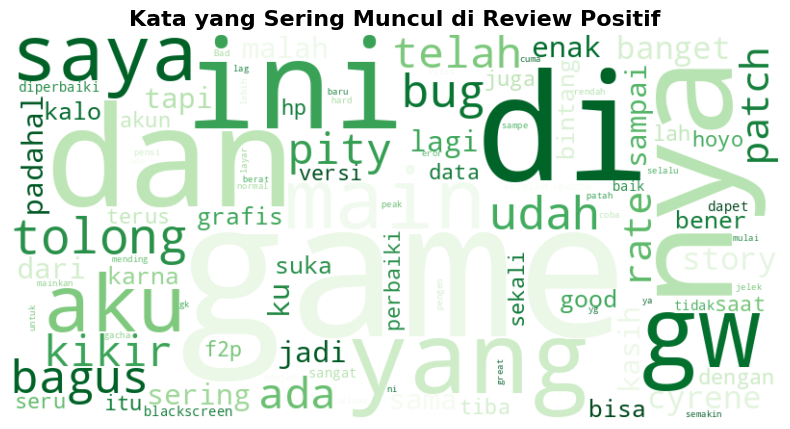

In [24]:
if not data_positif.empty:
    generate_wordcloud(data_positif, "Kata yang Sering Muncul di Review Positif", "Greens")
else:
    print("Tidak ada data Positif.")

In [25]:
if not data_negatif.empty:
    generate_wordcloud(data_negatif, "Kata yang Sering Muncul di Review negatif", "Greens")
else:
    print("Tidak ada data negatif.")

Tidak ada data negatif.


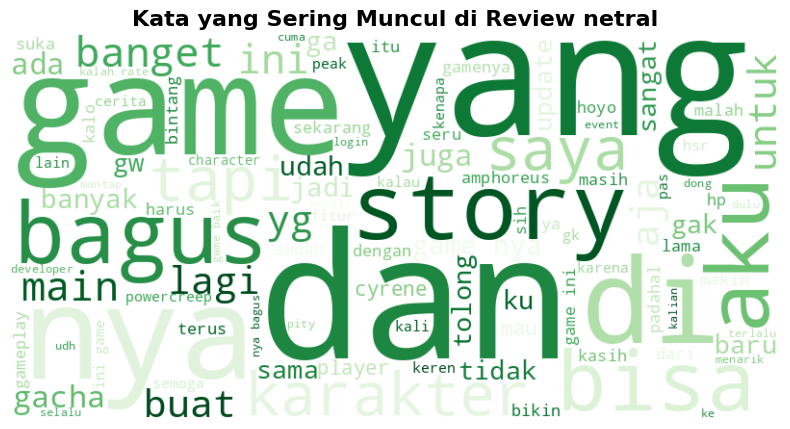

In [26]:
if not data_netral.empty:
    generate_wordcloud(data_netral, "Kata yang Sering Muncul di Review netral", "Greens")
else:
    print("Tidak ada data netral.")

dalam semua riview komentar dari positif,negatif dan netral

ini adalah label data dari ke semua ulasan dari label positif, netral dan negatif ada.

bisa di liat dari bawah ini, adalah berbeda banget dari kata kata nya yg di atas, disini sudah tau mengenai kata kata seperti negatif.

yg di atas tadi bisa dilihat kata negatif berupa tidak ada.

sedangkan disini ada kata negatif nya.
tetapi kata negatif justru malah kedalam kata yg berujung dari kata negatif, sedangkan kata netral malah ke arah kata ulasan bersumber negatif.


--- WordCloud Sentimen POSITIF ---


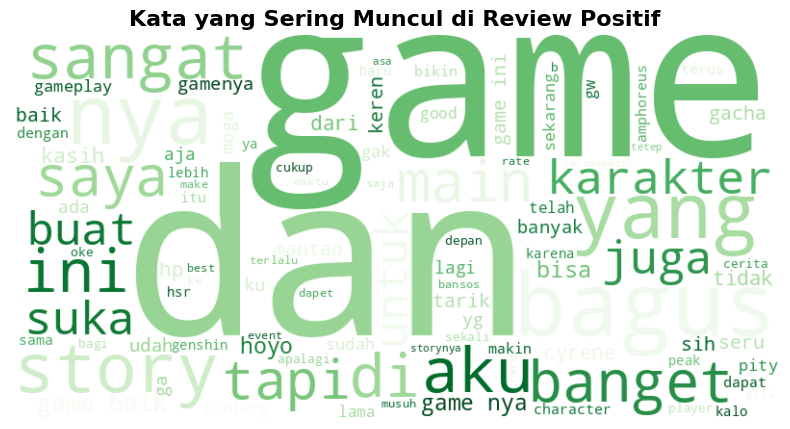


--- WordCloud Sentimen NEGATIF ---


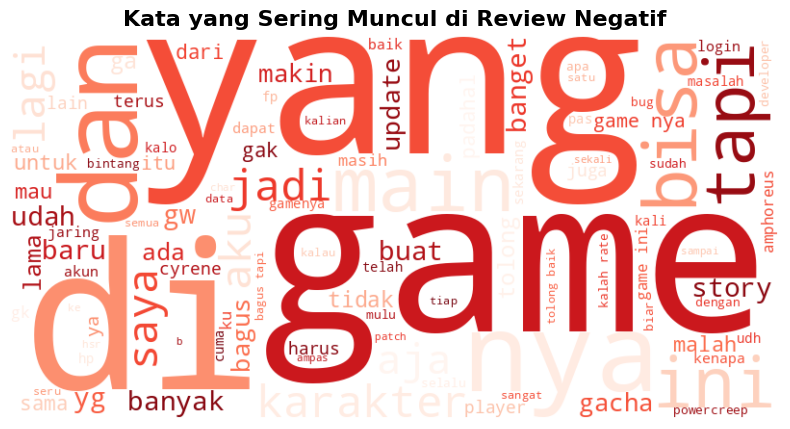


--- WordCloud Sentimen NETRAL ---


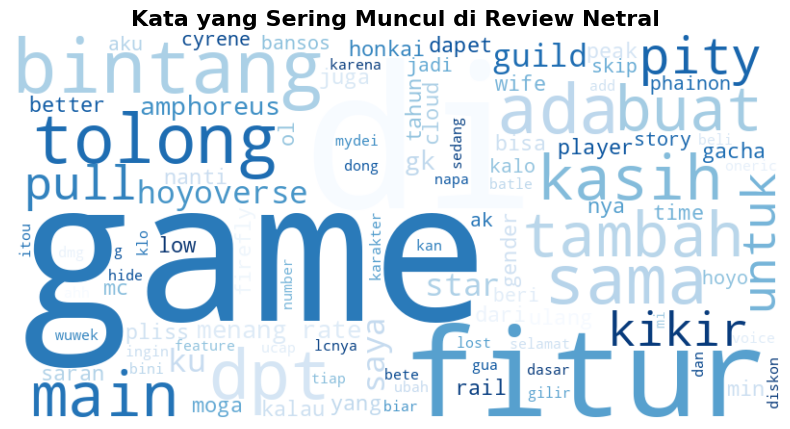

In [27]:
# --- A. WordCloud POSITIF ---
print("\n--- WordCloud Sentimen POSITIF ---")
if 'label' not in df.columns or 'processed_text' not in df.columns:
    print("Error: 'label' or 'processed_text' column not found in DataFrame. Please ensure the sentiment analysis and text processing steps (cells '7pmPvq-ENfys' and 'eh0CEeQuNi2f') have been executed completely.")
else:
    data_positif = df[df['label'] == 'Positif']['processed_text'].astype(str)

    if not data_positif.empty:
        generate_wordcloud(data_positif, "Kata yang Sering Muncul di Review Positif", "Greens")
    else:
        print("Tidak ada data Positif.")

    # --- B. WordCloud NEGATIF ---
    print("\n--- WordCloud Sentimen NEGATIF ---")
    data_negatif = df[df['label'] == 'Negatif']['processed_text'].astype(str)

    if not data_negatif.empty:
        generate_wordcloud(data_negatif, "Kata yang Sering Muncul di Review Negatif", "Reds")
    else:
        print("Tidak ada data Negatif.")

    # --- C. WordCloud NETRAL ---
    print("\n--- WordCloud Sentimen NETRAL ---")
    data_netral = df[df['label'] == 'Netral']['processed_text'].astype(str)

    if not data_netral.empty:
        generate_wordcloud(data_netral, "Kata yang Sering Muncul di Review Netral", "Blues")
    else:
        print("Tidak ada data Netral.")

# Representasi Teks (Feature Engineering)

In [28]:
!pip install nlp-id
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp_id.stopword import StopWord

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 13.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=32986e24d776bcdfa511ab1d314d6f62d5f1d6b725e2a4b9a0cc655dc6dc06dc
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0


In [29]:
# df = pd.read_csv('review_hoyovers_honkai_star_rail.csv') # This line caused the df to lose its 'label' column

In [30]:
print(df.columns)

Index(['reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt', 'appVersion', 'processed_text', 'label'],
      dtype='object')


In [31]:
# Membuat kolom cleaned_content dari kolom content
df['cleaned_content'] = df['content']

In [32]:
df['cleaned_content'] = df['cleaned_content'].fillna('')
df['cleaned_content'] = df['cleaned_content'].astype(str)

In [33]:
stopword_tool = StopWord()

def preprocess_for_tfidf(text):
    return stopword_tool.remove_stopword(text)

print("Membersihkan Stopword...")

df['text_for_tfidf'] = df['cleaned_content'].apply(preprocess_for_tfidf)


Membersihkan Stopword...


In [34]:
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['text_for_tfidf'])

print("Sukses! Ukuran Matriks:", tfidf_matrix.shape)

Sukses! Ukuran Matriks: (511, 1000)


## 6. Pemodelan: Machine Learning Tradisional

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# This cell is causing inconsistent vectorization for traditional ML models.
# The vectorization for Naive Bayes and SVM should already be handled in cell Z08kpg6lNls7.
# To fix the feature mismatch, this redundant vectorization will be removed.
# print("Sedang mengubah teks menjadi angka (TF-IDF)...")
# vectorizer = TfidfVectorizer(max_features=5000) # Membatasi 5000 kata terpenting
# tfidf_matrix = vectorizer.fit_transform(df['cleaned_content'])

In [37]:
# This assignment of X is inconsistent with the vectorizer used for prediction.
# The X_train and X_test for traditional ML models should come from Z08kpg6lNls7.
# X = tfidf_matrix

In [38]:
print("\nSedang melatih model Naive Bayes...")
model = MultinomialNB()
model.fit(X_train, y_train)
print("Selesai melatih model!")


Sedang melatih model Naive Bayes...
Selesai melatih model!


In [39]:
y_pred = model.predict(X_test)

In [40]:
akurasi = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model: {akurasi * 100:.2f}%")


Akurasi Model: 65.05%


In [41]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     Negatif       0.65      0.78      0.71        46
      Netral       0.00      0.00      0.00         9
     Positif       0.65      0.65      0.65        48

    accuracy                           0.65       103
   macro avg       0.43      0.48      0.45       103
weighted avg       0.59      0.65      0.62       103



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


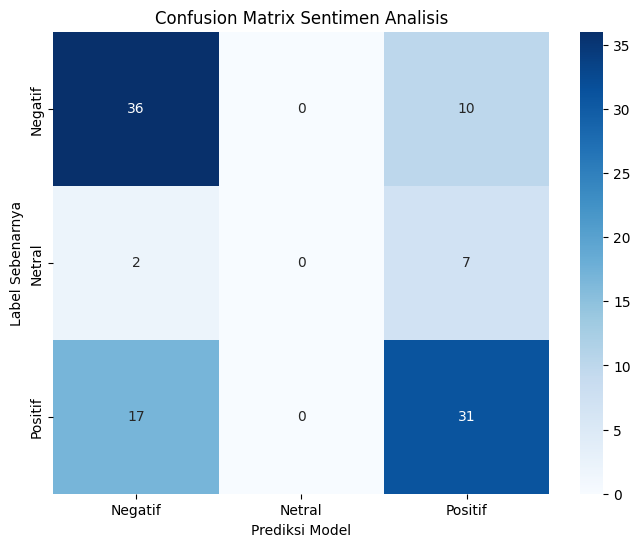

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix Sentimen Analisis')
plt.show()

## Support Vector Machine (SVM)

In [43]:
from sklearn.svm import SVC

In [44]:
print("Sedang melatih model SVM...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
print("Selesai melatih SVM!")

Sedang melatih model SVM...
Selesai melatih SVM!


In [45]:
y_pred_svm = svm_model.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nAkurasi SVM: {acc_svm * 100:.2f}%")
print(classification_report(y_test, y_pred_svm))


Akurasi SVM: 66.02%
              precision    recall  f1-score   support

     Negatif       0.64      0.85      0.73        46
      Netral       0.00      0.00      0.00         9
     Positif       0.69      0.60      0.64        48

    accuracy                           0.66       103
   macro avg       0.44      0.48      0.46       103
weighted avg       0.61      0.66      0.63       103



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Pemodelan: Deep Learning & Modern NLP

In [46]:
import numpy as np
import tensorflow as tf # Changed 'tensorflow' to 'tf' for common alias
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [47]:
texts = df['cleaned_content'].astype(str).values
labels = y

In [48]:
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(texts)
X_seq = tokenizer.texts_to_sequences(texts)

In [49]:
X_pad = pad_sequences(X_seq, maxlen=100)

In [50]:
le = LabelEncoder()
y_enc = le.fit_transform(labels)

In [51]:
from tensorflow.keras.utils import to_categorical
y_final = to_categorical(y_enc)

In [52]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_pad, y_final, test_size=0.2, random_state=42
)
print(f"Shape Data Latih DL: {X_train_dl.shape}")
print(f"Shape Label DL: {y_train_dl.shape}")

Shape Data Latih DL: (408, 100)
Shape Label DL: (408, 3)


In [53]:
model_dl = Sequential()

In [54]:
model_dl.add(Embedding(input_dim=5000, output_dim=128,
input_length=100))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
model_dl.add(SpatialDropout1D(0.2))

In [56]:
model_dl.add(Bidirectional(LSTM(64, dropout=0.2,
recurrent_dropout=0.2)))

In [57]:
model_dl.add(Dense(y_final.shape[1], activation='softmax'))
model_dl.compile(loss='categorical_crossentropy', optimizer='adam',
metrics=['accuracy'])
print(model_dl.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
history = model_dl.fit(
X_train_dl, y_train_dl,
epochs=5,
batch_size=32,
validation_data=(X_test_dl, y_test_dl),
verbose=1
)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 897ms/step - accuracy: 0.4744 - loss: 1.0225 - val_accuracy: 0.6117 - val_loss: 0.9068
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 518ms/step - accuracy: 0.5596 - loss: 0.9446 - val_accuracy: 0.6699 - val_loss: 0.8757
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 837ms/step - accuracy: 0.5812 - loss: 0.9132 - val_accuracy: 0.6796 - val_loss: 0.8348
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 661ms/step - accuracy: 0.6421 - loss: 0.8032 - val_accuracy: 0.6699 - val_loss: 0.7987
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 669ms/step - accuracy: 0.7688 - loss: 0.6922 - val_accuracy: 0.6699 - val_loss: 0.7896


## Evaluasi & Visualisasi

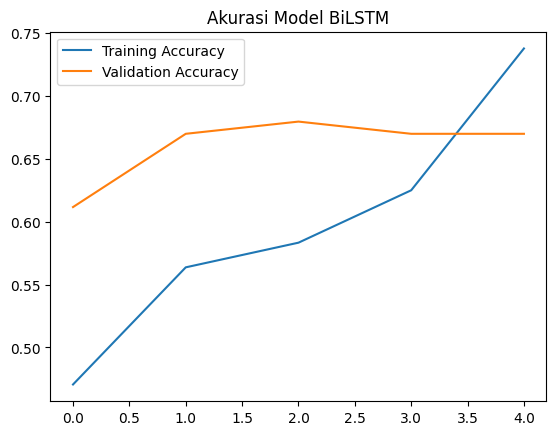

In [59]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model BiLSTM')
plt.legend()
plt.show()

In [60]:
# Evaluasi Angka
loss, accuracy = model_dl.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"\nAkurasi BiLSTM: {accuracy * 100:.2f}%")


Akurasi BiLSTM: 66.99%


## Kode Deployment / Prediksi Manual

In [61]:
import numpy as np
import re

In [62]:
def clean_and_prepare(text):
    # 1. Cleaning standar (Lowercase, hapus simbol)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # (Opsional: Tambahkan stopword removal/stemming di sini jika diperlukan)
    return text

In [63]:
# This cell is a partial and erroneous duplicate of the function defined in IIizUCPTbcSe. Removing it.

ini adalah sentimen yg terakhir, ketika ketik kata "keluar", maka ada kata selesai, makasih ya!

In [64]:
# 1. Dulu fungsinya didefinisikan
def clean_and_prepare(text):
    import re
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def predict_sentiment_all_models(text_input):
    print(f"\n--- Analisis untuk: '{text_input}' ---")

    cleaned_text = clean_and_prepare(text_input)
    text_vectorized = tfidf_vectorizer.transform([cleaned_text])

    if 'model' in globals():
        pred_nb = model.predict(text_vectorized)[0]
        print(f"[Naive Bayes] → {pred_nb}")

    if 'svm_model' in globals():
        pred_svm = svm_model.predict(text_vectorized)[0]
        print(f"[SVM Linear] → {pred_svm}")

    if 'model_dl' in globals():
        seq = tokenizer.texts_to_sequences([cleaned_text])
        padded = pad_sequences(seq, maxlen=100)
        pred_prob = model_dl.predict(padded, verbose=0)[0]
        pred_index = np.argmax(pred_prob)
        pred_label_dl = le.inverse_transform([pred_index])[0]
        confidence = pred_prob[pred_index] * 100
        print(f"[BiLSTM]     → {pred_label_dl} (Yakin: {confidence:.2f}%)")

# 2. Baru setelah itu loop interaktifnya
print("="*60)
print("     PROGRAM PREDIKSI SENTIMEN 3 MODEL")
print("     Ketik 'keluar' untuk berhenti")
print("="*60)

while True:
    input_user = input("\nMasukkan ulasan: ").strip()
    if input_user.lower() == 'keluar':
        print("Selesai. Makasih ya!")
        break
    if not input_user:
        print("Tulis sesuatu dong...")
        continue
    predict_sentiment_all_models(input_user)

     PROGRAM PREDIKSI SENTIMEN 3 MODEL
     Ketik 'keluar' untuk berhenti

Masukkan ulasan: keluar
Selesai. Makasih ya!
